<a href="https://colab.research.google.com/github/tomasdfen/AADLIS/blob/main/Pruebas_TFG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import numpy as np
import pandas as pd

from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.models import Model

from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_excel('/content/drive/MyDrive/Datos.xlsx', parse_dates=True, index_col=0)
df.head()

,AFN01,AFN02,AFN03,AFN04,AFN05,AFN06,AFN07,AFN08,AFN09,AFN10,AFN11,AFN12,AFN13,AFN14,AFN15,AFN16,AFN17,AFN18,AFN19,AFN20,AFN21,AFN22,AFN23,AFN24
Time (hh:mm:ss.ms),,,,,,,,,,,,,,,,,,,,,,,,
2021-02-16 05:55:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-02-16 05:56:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-02-16 05:57:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-02-16 05:58:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-02-16 05:59:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
df_test = pd.DataFrame(df.AFN01)

In [4]:
df_test

,AFN01
Time (hh:mm:ss.ms),
2021-02-16 05:55:00,0
2021-02-16 05:56:00,0
2021-02-16 05:57:00,0
2021-02-16 05:58:00,0
2021-02-16 05:59:00,0
...,...
2021-02-16 17:39:00,1
2021-02-16 17:40:00,1
2021-02-16 17:41:00,1


In [67]:
lag = 15
predict_window = 20
df_test = pd.DataFrame(df.AFN01)
df_test = df_test.resample("T").mean()
df_test.columns = ["t"]
for i in range(1,lag):
    df_test.insert(0, f"t-{i}", df_test["t"].shift(i))


df_test = df_test[lag+predict_window:]

In [68]:
df_test

,t-14,t-13,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
Time (hh:mm:ss.ms),,,,,,,,,,,,,,,
2021-02-16 06:30:00,3.0,3.0,3.0,4.0,4.0,5.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,8.0
2021-02-16 06:31:00,3.0,3.0,4.0,4.0,5.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,8.0,9.0
2021-02-16 06:32:00,3.0,4.0,4.0,5.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,8.0,9.0,9.0
2021-02-16 06:33:00,4.0,4.0,5.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,8.0,9.0,9.0,9.0
2021-02-16 06:34:00,4.0,5.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,8.0,9.0,9.0,9.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-16 17:39:00,14.0,13.0,11.0,11.0,9.0,9.0,8.0,7.0,6.0,5.0,4.0,3.0,3.0,2.0,1.0
2021-02-16 17:40:00,13.0,11.0,11.0,9.0,9.0,8.0,7.0,6.0,5.0,4.0,3.0,3.0,2.0,1.0,1.0
2021-02-16 17:41:00,11.0,11.0,9.0,9.0,8.0,7.0,6.0,5.0,4.0,3.0,3.0,2.0,1.0,1.0,1.0


In [69]:
x = df_test.values 
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

In [70]:
labels = df.AFN01[lag+predict_window:].resample("T").mean()

In [71]:
labels

Time (hh:mm:ss.ms)
2021-02-16 06:30:00     8.0
2021-02-16 06:31:00     9.0
2021-02-16 06:32:00     9.0
2021-02-16 06:33:00     9.0
2021-02-16 06:34:00    10.0
                       ... 
2021-02-16 17:39:00     1.0
2021-02-16 17:40:00     1.0
2021-02-16 17:41:00     1.0
2021-02-16 17:42:00     1.0
2021-02-16 17:43:00     0.0
Freq: T, Name: AFN01, Length: 674, dtype: float64

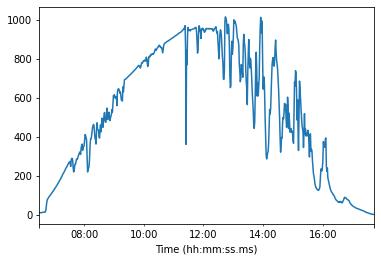

In [58]:
labels.plot()

In [75]:
input = Input((lag,1))
hidden = LSTM(32)(input)
hidden = Dense(64, activation='relu')(hidden)
output = Dense(1)(hidden)

model = Model(input, output)

In [76]:
model.compile(loss="mse", metrics="mse")

In [77]:
model.fit(x=x_scaled.reshape(*x_scaled.shape, 1), y=labels.values,epochs=10)

Epoch 1/10
22/22 [==============================] - 2s 6ms/step - loss: 388663.5924 - mse: 388663.5924
Epoch 2/10
22/22 [==============================] - 0s 7ms/step - loss: 370339.4226 - mse: 370339.4226
Epoch 3/10
22/22 [==============================] - 0s 7ms/step - loss: 353120.4946 - mse: 353120.4946
Epoch 4/10
22/22 [==============================] - 0s 7ms/step - loss: 358712.9878 - mse: 358712.9878
Epoch 5/10
22/22 [==============================] - 0s 7ms/step - loss: 371455.0177 - mse: 371455.0177
Epoch 6/10
22/22 [==============================] - 0s 7ms/step - loss: 352521.8111 - mse: 352521.8111
Epoch 7/10
22/22 [==============================] - 0s 7ms/step - loss: 322813.6916 - mse: 322813.6916
Epoch 8/10
22/22 [==============================] - 0s 7ms/step - loss: 319661.6114 - mse: 319661.6114
Epoch 9/10
22/22 [==============================] - 0s 7ms/step - loss: 336698.7310 - mse: 336698.7310
Epoch 10/10
22/22 [==============================] - 0s 8ms/step - loss: 